# Лабораторна робота №5

In [142]:
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt

class ImageIdentifier:
    def __init__(self, name):
        self.name = name
        self.image = imutils.resize(cv2.imread(name), width=600)
        self.hsv = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        self.mask = None
        self.outline_image = None
        self.image_identificated = None

    def set_mask(self, low, high):
        low_arr = np.array(low)
        high_arr = np.array(high)
        self.mask = cv2.inRange(self.hsv, low_arr, high_arr)

    def outline(self, outline_colour=(102, 255, 178)):
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(self.mask, kernel, iterations=2)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.outline_image = self.image.copy()
        cv2.drawContours(self.outline_image, contours, -1, outline_colour, 2)

    def identificate(self, outline_color=(102, 255, 178), text_color=(102, 255, 178)):
        kernel = np.ones((5, 5), np.uint8)
        connected_mask = cv2.dilate(self.mask, kernel, iterations=2)
        find_outline, _ = cv2.findContours(connected_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        areas = [cv2.contourArea(outline) for outline in find_outline]
        min_area_percent = np.quantile(areas, 0.95)

        self.image_identificated = self.image.copy()

        number_of_the_place = 0
        for outline in find_outline:
            if cv2.contourArea(outline) > min_area_percent:
                number_of_the_place += 1
                cv2.drawContours(self.image_identificated, [outline], -1, outline_color, 2)

                moments = cv2.moments(outline)
                center_x = int(moments['m10'] / moments['m00'])
                center_y = int(moments['m01'] / moments['m00'])
                text = f'Place {number_of_the_place}'
                font = cv2.FONT_HERSHEY_DUPLEX

                size, _ = cv2.getTextSize(text, font, 0.5, 2)
                offset_x = center_x - int(size[0] / 2)
                offset_y = center_y + int(size[1] / 2)
                cv2.putText(self.image_identificated, text, (offset_x, offset_y), font, 0.5, text_color, 2)

    def extract_fragment_rgb(self, x1, x2, y1, y2, show_fragment=True):
        fragment = self.image[y1:y2, x1:x2]

        if show_fragment:
            plt.imshow(fragment)
            plt.title(f"Image fragment in range X: {x1}-{x2}, Y: {y1}-{y2}")
            plt.show()

        fragment_rgb = cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB)
        avg_color_per_row = np.average(fragment_rgb, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)
        return avg_color

    def show_image(self):
        plt.imshow(self.image)
        plt.title(f"{self.name}")
        plt.show()

    def show_outlined_image(self):
        plt.imshow(self.outline_image)
        plt.title(f"Outlined image")
        plt.show()

    def show_identified_image(self):
        plt.imshow(self.image_identificated)
        plt.title(f"Identificated places")
        plt.show()



1. Let's create a class object and display the full image:

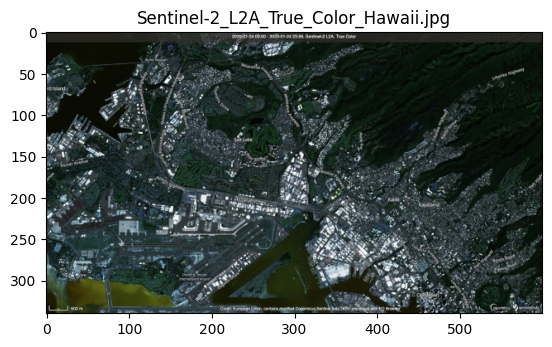

In [143]:
image_name = 'Sentinel-2_L2A_True_Color_Hawaii.jpg'
identifier = ImageIdentifier(image_name)

identifier.show_image()

2. Let's select two fragments of the image with a city and a forest and evaluate them by RGB:

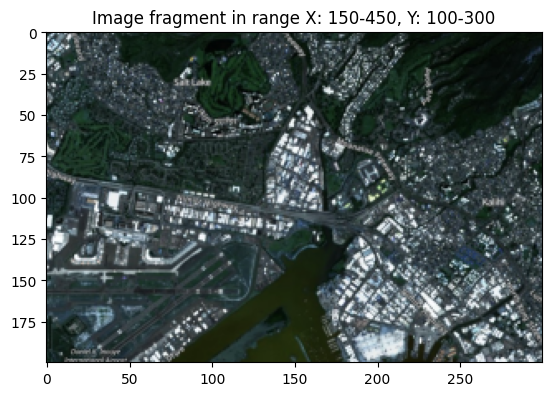

City fragment RGB: [69.5164     70.42845    57.44383333]


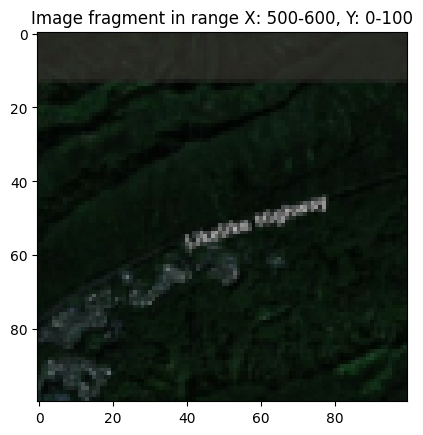

Forest fragment RGB: [17.4875 25.9643 15.9995]


In [144]:
rgb_city = identifier.extract_fragment_rgb(150, 450, 100, 300)
print(f"City fragment RGB: {rgb_city}")

rgb_forest = identifier.extract_fragment_rgb(500, 600, 0, 100)
print(f"Forest fragment RGB: {rgb_forest}")


3. As you can see, the fragments with the forest are obviously darker. Let's set the arguments of the `set_mask` function in the range from [`forest fragment RGB` + 10] to [`city fragment RGB` + 10]

In [145]:
identifier.set_mask([27, 35, 26], [80, 81, 67])

4. Let's display the results:

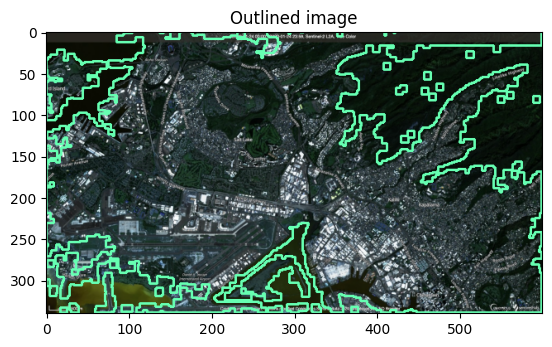

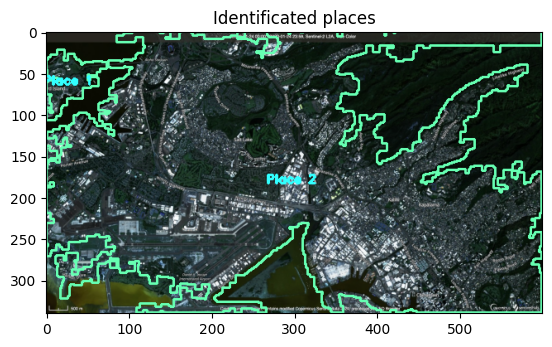

In [146]:
identifier.outline()
identifier.show_outlined_image()

identifier.identificate(text_color=(50, 255, 255))
identifier.show_identified_image()